<a href="https://colab.research.google.com/github/nowei/adversarial-dl/blob/master/projected_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# ResNet

*Author: Pytorch Team*

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

In [65]:
import torch
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet34', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet152', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [2]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
    classes = eval(f.read())

--2019-11-24 22:18:17--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2019-11-24 22:18:18 (2.43 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [0]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://pbs.twimg.com/media/DzIyOyEWwAAOxWv.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

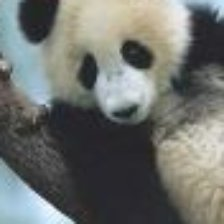

In [72]:
from IPython.display import Image as imshow
imshow(filename)


In [0]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import torch
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
data = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [5]:


def fgsm_attack(image, epsilon, data_graph):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    print('changed', torch.sum(epsilon*sign_data_grad))
    return perturbed_image

epsilon = 20/255
target = torch.zeros(1,dtype=torch.long)
target[0] = 1
device = 'cuda'
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    data = data.to(device)
    model.to(device)
    # Send the data and label to the device
    target = target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True
    
    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    print(classes[init_pred.item()], torch.nn.functional.softmax(output[0], dim=0).max())
    # Calculate the loss
    loss = F.nll_loss(output, target)
    
    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    # Re-classify the perturbed image
    output = model(perturbed_data)
    print('perturbedddddd')
# with torch.no_grad():
    # output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probs = torch.nn.functional.softmax(output[0], dim=0)

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca tensor(0.8202, device='cuda:0', grad_fn=<MaxBackward1>)
changed tensor(30.9020, device='cuda:0')
perturbedddddd


In [0]:
def proj_grad_desc(x, y, model, step_size=0.01, epsilon=4 * 1/255, steps=50, target=None):
    adversary = x.clone().detach().requires_grad_(True).to(x.device)
    max_diff = x + epsilon
    min_diff = x - epsilon
    for i in range(steps):
        curr = adversary.clone().detach().requires_grad_(True).to(adversary.device)
        output = model(curr)
        loss = F.nll_loss(output, target if target else y)
        loss.backward()
        with torch.no_grad():
            curr_grad = curr.grad * step_size 
            if target:
                adversary -= curr_grad
            else:
                adversary += curr_grad
        adversary = torch.max(torch.min(adversary, max_diff), min_diff)
        # adversary = adversary.clamp(0, 1)
    return adversary.detach()

In [0]:
trans = transforms.ToPILImage()

In [0]:
preprocess_2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
preprocess_3 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                   
])

In [76]:
label = torch.tensor([388]).to(data.device)
print(classes[label.item()])
target = torch.tensor([368]).to(data.device)
# target = None
if target:
    print(classes[target.item()])
adv = proj_grad_desc(data, label, model, 0.01, 4 * 1/255, steps=50, target=target)
print('nani')
# curr = preprocess_3(preprocess_2(input_image) + (data - adv).to('cpu'))
# print(curr)
# print(classes[model(curr.to(data.device)).argmax().item()])
# trans(curr[0].to('cpu')).save('nani.jpg')
trans(input_tensor.to('cpu')).save('nanie.jpg')
result = model(adv)
probs = torch.nn.functional.softmax(result[0], dim=0)
adv[:, 0, :, :] = adv[:, 0, :, :] * 0.229 + 0.485
adv[:, 1, :, :] = adv[:, 1, :, :] * 0.224 + 0.456
adv[:, 2, :, :] = adv[:, 2, :, :] * 0.225 + 0.406
print(classes[probs.argmax().item()], probs.max())
trans(adv.to('cpu')[0]).save('pgd_doggo.jpg')
adv[:, 0, :, :] = (adv[:, 0, :, :] - 0.485) / 0.229
adv[:, 1, :, :] = (adv[:, 1, :, :] - 0.456) / 0.224 
adv[:, 2, :, :] = (adv[:, 2, :, :] - 0.406) / 0.225
# trans(adv.to('cpu')[0]).save('pgd_doggo.jpg')
print(adv)
result = model(adv)
probs = torch.nn.functional.softmax(result[0], dim=0)
print(classes[probs.argmax().item()], probs.max())


giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
gibbon, Hylobates lar


KeyboardInterrupt: ignored

In [81]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      9 ?        00:00:06 node
     24 ?        00:00:11 jupyter-noteboo
    114 ?        00:00:00 tail
    122 ?        00:01:48 python3
   1281 ?        00:00:00 ps


In [20]:
print(classes[probs.argmax().item()])

gibbon, Hylobates lar


In [0]:
local = trans(perturbed_data.to('cpu')[0])
trans(data.to('cpu')[0]).save('orig_doggo.jpg')
local.save('doggo.jpg')

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn


In [63]:
#training
# train = datasets.ImageNet('./data/', train=True, transform=preprocess, download=True)
# train_loader = DataLoader(train, batch_size=128)
model_training = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=128,\
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=128, \
                                          shuffle=False)
model_training.to(device)
model_training.train()
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(50):
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        print(y)
        x_adv = proj_grad_desc(x, y, model, step_size=0.01, epsilon=4 * 1/255)
        optimizer.zero_grad()
        y_pred = model_training(x_adv)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
    print("epoch {}: loss {}".format(epoch, loss.item()))
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x_adv = proj_grad_desc(x, y, model, step_size=0.01, epsilon=4 * 1/255)
            optimizer.zero_grad()
            y_pred = model_training(x_adv)
            test_loss_on = F.cross_entropy(output, label.squeeze(), reduction='elementwise_mean')
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print("epoch {}: {}% accuracy".format(epoch, test_accuracy*100))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2


tensor([[ 37],
        [153],
        [106],
        [173],
        [175],
        [134],
        [145],
        [195],
        [178],
        [183],
        [161],
        [107],
        [187],
        [111],
        [191],
        [184],
        [ 95],
        [ 19],
        [ 32],
        [103],
        [196],
        [129],
        [ 18],
        [ 59],
        [ 13],
        [ 97],
        [197],
        [122],
        [ 37],
        [ 63],
        [ 83],
        [123],
        [ 51],
        [117],
        [  3],
        [  0],
        [ 83],
        [185],
        [ 18],
        [162],
        [ 44],
        [191],
        [161],
        [108],
        [ 81],
        [ 17],
        [ 34],
        [ 82],
        [ 97],
        [167],
        [ 23],
        [ 97],
        [185],
        [ 98],
        [ 40],
        [153],
        [ 56],
        [ 31],
        [ 65],
        [185],
        [ 60],
        [ 76],
        [171],
        [ 87],
        [182],
        [ 25],
        [1

RuntimeError: ignored

In [64]:
!nvidia-smi

Mon Nov 25 00:49:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |  15915MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [33]:
import os

BASE_PATH = './'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !ls
    !rm homework2.tar

/content
data	   dog.jpg			      nanie.jpg       pgd_doggo.jpg
doggo.jpg  imagenet1000_clsidx_to_labels.txt  orig_doggo.jpg  sample_data
--2019-11-24 23:10:12--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1327554560 (1.2G) [application/x-tar]
Saving to: ‘homework2.tar’

homework2.tar       100%[===================>]   1.24G  19.4MB/s    in 59s     

2019-11-24 23:11:11 (21.5 MB/s) - ‘homework2.tar’ saved [1327554560/1327554560]

pt_util.py
tiny_imagenet/
tiny_imagenet/train.h5
tiny_imagenet/class_names.txt
tiny_imagenet/val.h5
data	   homework2.tar		      orig_doggo.jpg  sample_data
doggo.jpg  imagenet1000_clsidx_to_labels.txt  pgd_doggo.jpg   tiny_imagenet
dog.jpg    nanie.jpg			      pt_util.py


In [0]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        # TODO Implement data loading.
        f = h5py.File(h5_file, 'r')
        self.images = f['images'][...]
        self.labels = np.asarray(f['labels'][...], dtype='int64')
        print(self.images.shape)
        f.close()
        self.transform = transform

    def __len__(self):
        # TODO Implement the length function
        return len(self.labels)

    def __getitem__(self, idx):
        # TODO implement the getitem function
        # You should return a tuple of:
        #    a torch tensor containing single image in CxHxW format and
        #    the label as a single tensor scalar.
        data = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        return (data, label)


In [57]:
import h5py
import numpy as np

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=preprocess)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=preprocess)
print(len(data_test))


(100000, 64, 64, 3)
100000
(8000, 64, 64, 3)
8000


In [0]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Model Description

Resnet models were proposed in "Deep Residual Learning for Image Recognition".
Here we have the 5 versions of resnet models, which contains 5, 34, 50, 101, 152 layers respectively.
Detailed model architectures can be found in Table 1.
Their 1-crop error rates on imagenet dataset with pretrained models are listed below.

| Model structure | Top-1 error | Top-5 error |
| --------------- | ----------- | ----------- |
|  resnet18       | 30.24       | 10.92       |
|  resnet34       | 26.70       | 8.58        |
|  resnet50       | 23.85       | 7.13        |
|  resnet101      | 22.63       | 6.44        |
|  resnet152      | 21.69       | 5.94        |

### References

 - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)